# **Deep Learning Course**

## **Loss Functions and Multilayer Perceptrons (MLP)**

---

### **Student Information:**

- **Name:** Parnian Taheri
- **Student Number:** 99106352

---

### **Assignment Overview**

In this notebook, we will explore various loss functions used in neural networks, with a specific focus on their role in training **Multilayer Perceptrons (MLPs)**. By the end of this notebook, you will have a deeper understanding of:
- Types of loss functions
- How loss functions affect the training process
- The relationship between loss functions and model optimization in MLPs

---

### **Table of Contents**

1. Introduction to Loss Functions
2. Types of Loss Functions
3. Multilayer Perceptrons (MLP)
4. Implementing Loss Functions in MLP
5. Conclusion

---



# 1.Introduction to Loss Functions

In deep learning, **loss functions** play a crucial role in training models by quantifying the difference between the predicted outputs and the actual targets. Selecting the appropriate loss function is essential for the success of your model. In this assay, we will explore various loss functions available in PyTorch, understand their theoretical backgrounds, and provide you with a scaffolded class to experiment with these loss functions.

Before begining, let's train a simle MLP model using the **L1Loss** function. We'll return to this model later to experiment with different loss functions. We'll start by importing the necessary libraries and defining the model architecture.

First things first, let's talk about **L1Loss**.

### 1. L1Loss (`torch.nn.L1Loss`)
- **Description:** Also known as Mean Absolute Error (MAE), L1Loss computes the average absolute difference between the predicted values and the target values.
- **Use Case:** Suitable for regression tasks where robustness to outliers is desired.

Here is the mathematical formulation of L1Loss:
\begin{equation}
\text{L1Loss} = \frac{1}{n} \sum_{i=1}^{n} |y_{\text{pred}_i} - y_{\text{true}_i}|
\end{equation}

Let's implement a simple MLP model using the L1Loss function.

In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
# Don't be courious about Adam, it's just a fancy name for a fancy optimization algorithm

Here, we'll define a class called `SimpleMLP` that inherits from `nn.Module`. This class can have multiple layers, and we'll use the `nn.Sequential` module to define the layers of the model. The model will have the following architecture:

In [114]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers=1, last_layer_activation_fn=nn.ReLU):
        super(SimpleMLP, self).__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(last_layer_activation_fn(dim=1) if last_layer_activation_fn == nn.LogSoftmax else last_layer_activation_fn())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

Now, let's define a class called `SimpleMLP_Loss` that has the following architecture:

In [115]:
class SimpleMLPTrainer:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

    def train(self, train_loader, num_epochs):
        self.model.train()
        epoch_losses = []
        epoch_accuracies = []

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

            for inputs, targets in progress_bar:
                inputs, targets = inputs.to(device), targets.to(device)

                predictions = self.model(inputs)

                loss = self.criterion(predictions, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

                if predictions.shape[-1] == 1:  # Binary classification or regression
                    correct_predictions += ((predictions > 0.5) == targets).sum().item()
                else:  # Multi-class classification
                    _, predicted_classes = predictions.max(1)
                    predicted_classes = predicted_classes.view(-1,1)
                    correct_predictions += (predicted_classes == targets).sum().item()
                total_predictions += targets.size(0)

                progress_bar.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = correct_predictions / total_predictions * 100
            epoch_losses.append(epoch_loss)
            epoch_accuracies.append(epoch_accuracy)

            print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%")

        return epoch_losses, epoch_accuracies

    def evaluate(self, val_loader):
        self.model.eval()
        val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                predictions = self.model(inputs)
                loss = self.criterion(predictions, targets)

                val_loss += loss.item()

                if predictions.shape[-1] == 1:  # Binary classification or regression
                    correct_predictions += ((predictions > 0.5) == targets).sum().item()
                else:  # Multi-class classification
                    _, predicted_classes = predictions.max(1)
                    predicted_classes = predicted_classes.view(-1,1)
                    correct_predictions += (predicted_classes == targets).sum().item()
                total_predictions += targets.size(0)

        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct_predictions / total_predictions * 100

        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

        return avg_val_loss, accuracy

Next, lets test our model using the L1Loss function. You'll use <span style="color:red">*Titanic Dataset*</span> to train the model.


In [116]:
# Load dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(train_url)

# Preprocessing (simple example)
data = data[['Pclass', 'Sex', 'Age', 'Fare', 'Survived']].dropna()
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

# TODO: Convert the data to PyTorch tensors and create a DataLoader
X = data[['Pclass', 'Sex', 'Age', 'Fare']].values
y = data['Survived'].values
# TODO: Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

# TODO: Define the model, criterion, and optimizer
input_dim = 4
hidden_dim = 10
output_dim = 1
num_hidden_layers = 2
model = SimpleMLP(input_dim, hidden_dim, output_dim, num_hidden_layers).to(device)

# Loss function and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


<div style="text-align: center;"> <span style="color:red; font-size: 26px; font-weight: bold;">Let's train!</span> </div>

In [117]:
from torch.nn import L1Loss
input_dim = 4
hidden_dim = 10
output_dim = 1
num_hidden_layers = 2
model = SimpleMLP(input_dim, hidden_dim, output_dim, num_hidden_layers).to(device)

# Loss function and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = SimpleMLPTrainer(model, criterion, optimizer)

# Train the model
train_loss, train_acc = trainer.train(train_loader, num_epochs=20)

# Evaluate the model
test_loss, test_acc = trainer.evaluate(val_loader)

Epoch 1/20: 100%|██████████| 17/17 [00:00<00:00, 158.44it/s, loss=0.344]


Epoch [1/20], Training Loss: 0.4136, Training Accuracy: 58.64%


Epoch 2/20: 100%|██████████| 17/17 [00:00<00:00, 151.50it/s, loss=0.375]


Epoch [2/20], Training Loss: 0.4062, Training Accuracy: 59.38%


Epoch 3/20: 100%|██████████| 17/17 [00:00<00:00, 171.62it/s, loss=0.281]


Epoch [3/20], Training Loss: 0.4081, Training Accuracy: 59.19%


Epoch 4/20: 100%|██████████| 17/17 [00:00<00:00, 178.81it/s, loss=0.438]


Epoch [4/20], Training Loss: 0.4044, Training Accuracy: 59.56%


Epoch 5/20: 100%|██████████| 17/17 [00:00<00:00, 155.93it/s, loss=0.469]


Epoch [5/20], Training Loss: 0.4118, Training Accuracy: 58.82%


Epoch 6/20: 100%|██████████| 17/17 [00:00<00:00, 150.69it/s, loss=0.562]


Epoch [6/20], Training Loss: 0.4044, Training Accuracy: 59.56%


Epoch 7/20: 100%|██████████| 17/17 [00:00<00:00, 153.56it/s, loss=0.438]


Epoch [7/20], Training Loss: 0.4026, Training Accuracy: 59.74%


Epoch 8/20: 100%|██████████| 17/17 [00:00<00:00, 146.92it/s, loss=0.469]


Epoch [8/20], Training Loss: 0.4081, Training Accuracy: 59.19%


Epoch 9/20: 100%|██████████| 17/17 [00:00<00:00, 125.06it/s, loss=0.344]


Epoch [9/20], Training Loss: 0.4154, Training Accuracy: 58.46%


Epoch 10/20: 100%|██████████| 17/17 [00:00<00:00, 60.52it/s, loss=0.5]


Epoch [10/20], Training Loss: 0.4081, Training Accuracy: 59.19%


Epoch 11/20: 100%|██████████| 17/17 [00:00<00:00, 64.56it/s, loss=0.469]


Epoch [11/20], Training Loss: 0.4081, Training Accuracy: 59.19%


Epoch 12/20: 100%|██████████| 17/17 [00:00<00:00, 65.89it/s, loss=0.219]


Epoch [12/20], Training Loss: 0.4118, Training Accuracy: 58.82%


Epoch 13/20: 100%|██████████| 17/17 [00:00<00:00, 103.79it/s, loss=0.406]


Epoch [13/20], Training Loss: 0.4118, Training Accuracy: 58.82%


Epoch 14/20: 100%|██████████| 17/17 [00:00<00:00, 121.80it/s, loss=0.531]


Epoch [14/20], Training Loss: 0.4099, Training Accuracy: 59.01%


Epoch 15/20: 100%|██████████| 17/17 [00:00<00:00, 94.25it/s, loss=0.406]


Epoch [15/20], Training Loss: 0.4081, Training Accuracy: 59.19%


Epoch 16/20: 100%|██████████| 17/17 [00:00<00:00, 111.91it/s, loss=0.344]


Epoch [16/20], Training Loss: 0.4118, Training Accuracy: 58.82%


Epoch 17/20: 100%|██████████| 17/17 [00:00<00:00, 102.21it/s, loss=0.281]


Epoch [17/20], Training Loss: 0.4173, Training Accuracy: 58.27%


Epoch 18/20: 100%|██████████| 17/17 [00:00<00:00, 125.13it/s, loss=0.219]


Epoch [18/20], Training Loss: 0.4062, Training Accuracy: 59.38%


Epoch 19/20: 100%|██████████| 17/17 [00:00<00:00, 103.93it/s, loss=0.469]


Epoch [19/20], Training Loss: 0.4118, Training Accuracy: 58.82%


Epoch 20/20: 100%|██████████| 17/17 [00:00<00:00, 110.55it/s, loss=0.281]


Epoch [20/20], Training Loss: 0.4118, Training Accuracy: 58.82%
Validation Loss: 0.3906, Validation Accuracy: 60.94%


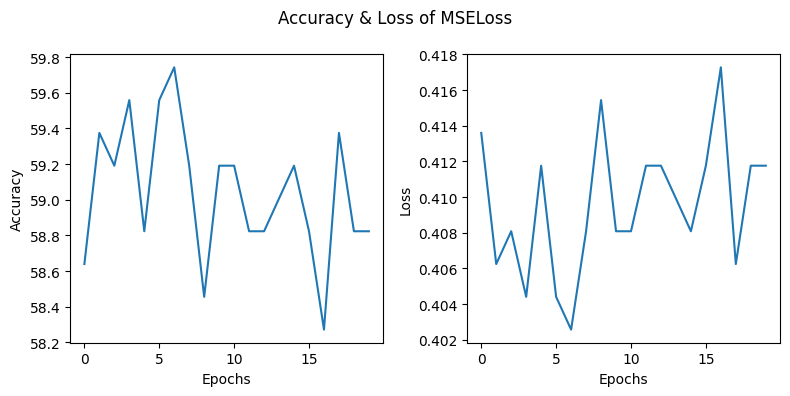

In [118]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(train_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.subplot(1,2,2)
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.suptitle("Accuracy & Loss of MSELoss")
plt.tight_layout()
plt.show()

---
# 2. Types of Loss Functions

PyTorch offers a variety of built-in loss functions tailored for different types of problems, such as regression, classification, and more. Below, we discuss several commonly used loss functions, their theoretical foundations, and typical use cases.

### 2. MSELoss (`torch.nn.MSELoss`)
- **Description:** Mean Squared Error (MSE) calculates the average of the squares of the differences between predicted and target values.
- **Use Case:** Commonly used in regression problems where larger errors are significantly penalized.

Here is boring math stuff for MSE:
\begin{equation}
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}
\end{equation}

<span style="color:red; font-size: 18px; font-weight: bold;">Warning:</span> Don't forget to reinitialize the model before experimenting with different loss functions.

In [119]:
from torch.nn import MSELoss
input_dim = 4
hidden_dim = 20
output_dim = 1
num_hidden_layers = 5
model = SimpleMLP(input_dim, hidden_dim, output_dim, num_hidden_layers).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = SimpleMLPTrainer(model, criterion, optimizer)

# TODO: Train the model
train_loss, train_acc = trainer.train(train_loader, num_epochs=20)

# Evaluate the model
test_loss, test_acc = trainer.evaluate(val_loader)

Epoch 1/20: 100%|██████████| 17/17 [00:00<00:00, 103.49it/s, loss=0.275]


Epoch [1/20], Training Loss: 0.2892, Training Accuracy: 60.48%


Epoch 2/20: 100%|██████████| 17/17 [00:00<00:00, 78.34it/s, loss=0.203]


Epoch [2/20], Training Loss: 0.2322, Training Accuracy: 65.26%


Epoch 3/20: 100%|██████████| 17/17 [00:00<00:00, 76.63it/s, loss=0.179]


Epoch [3/20], Training Loss: 0.2140, Training Accuracy: 66.91%


Epoch 4/20: 100%|██████████| 17/17 [00:00<00:00, 39.25it/s, loss=0.174]


Epoch [4/20], Training Loss: 0.2142, Training Accuracy: 66.54%


Epoch 5/20: 100%|██████████| 17/17 [00:00<00:00, 55.46it/s, loss=0.14]


Epoch [5/20], Training Loss: 0.2089, Training Accuracy: 66.73%


Epoch 6/20: 100%|██████████| 17/17 [00:00<00:00, 69.28it/s, loss=0.178]


Epoch [6/20], Training Loss: 0.2073, Training Accuracy: 65.07%


Epoch 7/20: 100%|██████████| 17/17 [00:00<00:00, 67.19it/s, loss=0.223]


Epoch [7/20], Training Loss: 0.2039, Training Accuracy: 65.81%


Epoch 8/20: 100%|██████████| 17/17 [00:00<00:00, 95.84it/s, loss=0.21]


Epoch [8/20], Training Loss: 0.2023, Training Accuracy: 68.20%


Epoch 9/20: 100%|██████████| 17/17 [00:00<00:00, 34.71it/s, loss=0.204]


Epoch [9/20], Training Loss: 0.2062, Training Accuracy: 68.75%


Epoch 10/20: 100%|██████████| 17/17 [00:00<00:00, 47.08it/s, loss=0.209]


Epoch [10/20], Training Loss: 0.2027, Training Accuracy: 69.85%


Epoch 11/20: 100%|██████████| 17/17 [00:00<00:00, 30.08it/s, loss=0.224]


Epoch [11/20], Training Loss: 0.2089, Training Accuracy: 67.10%


Epoch 12/20: 100%|██████████| 17/17 [00:00<00:00, 29.49it/s, loss=0.2]


Epoch [12/20], Training Loss: 0.2013, Training Accuracy: 68.93%


Epoch 13/20: 100%|██████████| 17/17 [00:00<00:00, 36.24it/s, loss=0.198]


Epoch [13/20], Training Loss: 0.2047, Training Accuracy: 69.30%


Epoch 14/20: 100%|██████████| 17/17 [00:00<00:00, 25.75it/s, loss=0.202]


Epoch [14/20], Training Loss: 0.2028, Training Accuracy: 69.49%


Epoch 15/20: 100%|██████████| 17/17 [00:00<00:00, 34.63it/s, loss=0.21]


Epoch [15/20], Training Loss: 0.2003, Training Accuracy: 69.12%


Epoch 16/20: 100%|██████████| 17/17 [00:00<00:00, 75.77it/s, loss=0.241] 


Epoch [16/20], Training Loss: 0.2007, Training Accuracy: 70.96%


Epoch 17/20: 100%|██████████| 17/17 [00:00<00:00, 49.47it/s, loss=0.189]


Epoch [17/20], Training Loss: 0.1993, Training Accuracy: 70.22%


Epoch 18/20: 100%|██████████| 17/17 [00:00<00:00, 52.47it/s, loss=0.206]


Epoch [18/20], Training Loss: 0.1976, Training Accuracy: 71.88%


Epoch 19/20: 100%|██████████| 17/17 [00:00<00:00, 40.73it/s, loss=0.181]


Epoch [19/20], Training Loss: 0.2024, Training Accuracy: 69.85%


Epoch 20/20: 100%|██████████| 17/17 [00:00<00:00, 57.13it/s, loss=0.24]


Epoch [20/20], Training Loss: 0.1992, Training Accuracy: 70.04%
Validation Loss: 0.2293, Validation Accuracy: 64.06%


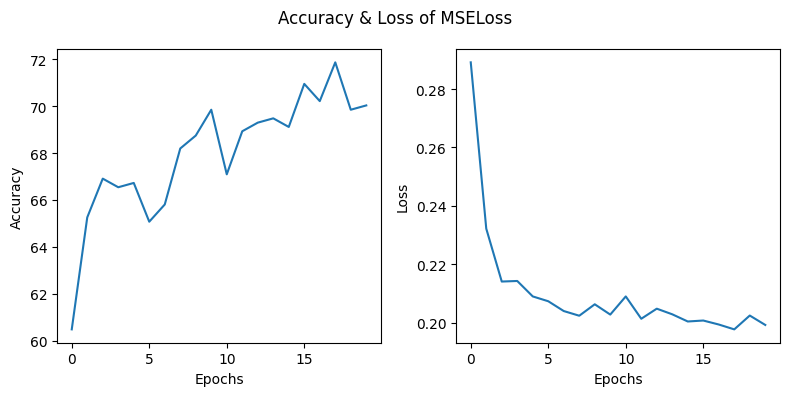

In [120]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(train_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.subplot(1,2,2)
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.suptitle("Accuracy & Loss of MSELoss")
plt.tight_layout()
plt.show()

### 3. NLLLoss (`torch.nn.NLLLoss`)
- **Description:** Negative Log-Likelihood Loss measures the likelihood of the target class under the predicted probability distribution.
- **Use Case:** Typically used in multi-class classification tasks, especially when combined with `log_softmax` activation.

Here is the mathematical formulation of NLLLoss:
\begin{equation}
\text{NLLLoss} = -\frac{1}{n} \sum_{i=1}^{n} \log(y_{i})
\end{equation}

I hope you note the logarithm in the formula. It's important!

Why?

Answer: Numerical Stability: The softmax activation produces probabilities close to zero for classes with low likelihoods. Applying a log to these probabilities (which can be very small) prevents numerical underflow and makes the calculations more stable.
Interpretability: The logarithm converts multiplicative relationships in probability space into additive relationships, which is more manageable for optimization during training.

In this part, run your training with Relu at last layer. <span style="color:red; font-weight: bold;">Discuss </span> and explain the difference between the results of the two models. Find a proper solution to the problem.


# Need to define new model

In [121]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long).view(-1, 1)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

class SimpleMLPTrainer_NLLLoss:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

    def train(self, train_loader, num_epochs):
        self.model.train()
        epoch_losses = []
        epoch_accuracies = []

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

            for inputs, targets in progress_bar:
                targets = targets.view(-1)
                inputs, targets = inputs.to(device), targets.to(device)

                predictions = self.model(inputs)

                loss = self.criterion(predictions, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

                if predictions.shape[-1] == 1:  # Binary classification or regression
                    correct_predictions += ((predictions > 0.5) == targets).sum().item()
                else:  # Multi-class classification
                    _, predicted_classes = predictions.max(1)
                    correct_predictions += (predicted_classes == targets).sum().item()
                total_predictions += targets.size(0)

                progress_bar.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = correct_predictions / total_predictions * 100
            epoch_losses.append(epoch_loss)
            epoch_accuracies.append(epoch_accuracy)

            print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%")

        return epoch_losses, epoch_accuracies

    def evaluate(self, val_loader):
        self.model.eval()
        val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                targets = targets.view(-1)
                inputs, targets = inputs.to(device), targets.to(device)

                predictions = self.model(inputs)
                loss = self.criterion(predictions, targets)

                val_loss += loss.item()

                if predictions.shape[-1] == 1:  # Binary classification or regression
                    correct_predictions += ((predictions > 0.5) == targets).sum().item()
                else:  # Multi-class classification
                    _, predicted_classes = predictions.max(1)
                    correct_predictions += (predicted_classes == targets).sum().item()
                total_predictions += targets.size(0)

        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct_predictions / total_predictions * 100

        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

        return avg_val_loss, accuracy

In [122]:
# Run with relu activation function
from torch.nn import NLLLoss
input_dim = 4
hidden_dim = 10
output_dim = 4
num_hidden_layers = 2
model = SimpleMLP(input_dim, hidden_dim, output_dim, num_hidden_layers).to(device)

# Loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = SimpleMLPTrainer_NLLLoss(model, criterion, optimizer)


# TODO: Train the model
train_loss_relu, train_acc_relu = trainer.train(train_loader, num_epochs=20)

# Evaluate the model
test_loss_relu, test_acc_relu = trainer.evaluate(val_loader)

Epoch 1/20: 100%|██████████| 17/17 [00:00<00:00, 55.86it/s, loss=-0.854]


Epoch [1/20], Training Loss: -0.8715, Training Accuracy: 12.50%


Epoch 2/20: 100%|██████████| 17/17 [00:00<00:00, 97.52it/s, loss=-3.31] 


Epoch [2/20], Training Loss: -2.3836, Training Accuracy: 41.91%


Epoch 3/20: 100%|██████████| 17/17 [00:00<00:00, 145.63it/s, loss=-5.06]


Epoch [3/20], Training Loss: -4.1908, Training Accuracy: 56.25%


Epoch 4/20: 100%|██████████| 17/17 [00:00<00:00, 75.89it/s, loss=-9.17]


Epoch [4/20], Training Loss: -7.2888, Training Accuracy: 58.82%


Epoch 5/20: 100%|██████████| 17/17 [00:00<00:00, 109.03it/s, loss=-18.2]


Epoch [5/20], Training Loss: -11.6538, Training Accuracy: 59.38%


Epoch 6/20: 100%|██████████| 17/17 [00:00<00:00, 36.70it/s, loss=-18.2]


Epoch [6/20], Training Loss: -17.8805, Training Accuracy: 58.64%


Epoch 7/20: 100%|██████████| 17/17 [00:00<00:00, 44.83it/s, loss=-33.4]


Epoch [7/20], Training Loss: -28.4873, Training Accuracy: 59.56%


Epoch 8/20: 100%|██████████| 17/17 [00:00<00:00, 34.83it/s, loss=-58.3]


Epoch [8/20], Training Loss: -43.1495, Training Accuracy: 58.82%


Epoch 9/20: 100%|██████████| 17/17 [00:00<00:00, 39.71it/s, loss=-66.6]


Epoch [9/20], Training Loss: -62.6855, Training Accuracy: 59.19%


Epoch 10/20: 100%|██████████| 17/17 [00:00<00:00, 55.86it/s, loss=-105]


Epoch [10/20], Training Loss: -89.9297, Training Accuracy: 59.56%


Epoch 11/20: 100%|██████████| 17/17 [00:00<00:00, 52.43it/s, loss=-178]


Epoch [11/20], Training Loss: -127.3064, Training Accuracy: 58.64%


Epoch 12/20: 100%|██████████| 17/17 [00:00<00:00, 42.47it/s, loss=-220]


Epoch [12/20], Training Loss: -171.6877, Training Accuracy: 59.19%


Epoch 13/20: 100%|██████████| 17/17 [00:00<00:00, 60.22it/s, loss=-263]


Epoch [13/20], Training Loss: -227.4009, Training Accuracy: 59.01%


Epoch 14/20: 100%|██████████| 17/17 [00:00<00:00, 30.50it/s, loss=-313]


Epoch [14/20], Training Loss: -295.1342, Training Accuracy: 59.01%


Epoch 15/20: 100%|██████████| 17/17 [00:00<00:00, 51.51it/s, loss=-362]


Epoch [15/20], Training Loss: -376.4177, Training Accuracy: 59.01%


Epoch 16/20: 100%|██████████| 17/17 [00:00<00:00, 67.36it/s, loss=-514]


Epoch [16/20], Training Loss: -476.3425, Training Accuracy: 58.82%


Epoch 17/20: 100%|██████████| 17/17 [00:00<00:00, 80.51it/s, loss=-617]


Epoch [17/20], Training Loss: -586.3528, Training Accuracy: 59.56%


Epoch 18/20: 100%|██████████| 17/17 [00:00<00:00, 67.68it/s, loss=-883]


Epoch [18/20], Training Loss: -726.2752, Training Accuracy: 59.01%


Epoch 19/20: 100%|██████████| 17/17 [00:00<00:00, 60.11it/s, loss=-1.04e+3]


Epoch [19/20], Training Loss: -878.8172, Training Accuracy: 58.64%


Epoch 20/20: 100%|██████████| 17/17 [00:00<00:00, 37.62it/s, loss=-1.21e+3]


Epoch [20/20], Training Loss: -1049.8597, Training Accuracy: 59.19%
Validation Loss: -1122.9650, Validation Accuracy: 60.94%


In [123]:
# Run with --- activation function
from torch.nn import NLLLoss
input_dim = 4
hidden_dim = 30
output_dim = 4
num_hidden_layers = 5
model = SimpleMLP(input_dim, hidden_dim, output_dim, num_hidden_layers, last_layer_activation_fn = nn.LogSoftmax).to(device)

# Loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = SimpleMLPTrainer_NLLLoss(model, criterion, optimizer)

# TODO: Train the model
train_loss_soft, train_acc_soft = trainer.train(train_loader, num_epochs=20)

# Evaluate the model
test_loss_soft, test_acc_soft = trainer.evaluate(val_loader)

Epoch 1/20: 100%|██████████| 17/17 [00:00<00:00, 57.89it/s, loss=1.13]


Epoch [1/20], Training Loss: 1.2646, Training Accuracy: 42.83%


Epoch 2/20: 100%|██████████| 17/17 [00:00<00:00, 49.89it/s, loss=0.746]


Epoch [2/20], Training Loss: 0.8952, Training Accuracy: 62.87%


Epoch 3/20: 100%|██████████| 17/17 [00:00<00:00, 34.33it/s, loss=0.662]


Epoch [3/20], Training Loss: 0.6511, Training Accuracy: 67.10%


Epoch 4/20: 100%|██████████| 17/17 [00:00<00:00, 41.16it/s, loss=0.596]


Epoch [4/20], Training Loss: 0.6218, Training Accuracy: 67.65%


Epoch 5/20: 100%|██████████| 17/17 [00:00<00:00, 24.52it/s, loss=0.645]


Epoch [5/20], Training Loss: 0.6179, Training Accuracy: 68.57%


Epoch 6/20: 100%|██████████| 17/17 [00:00<00:00, 33.59it/s, loss=0.758]


Epoch [6/20], Training Loss: 0.6364, Training Accuracy: 67.83%


Epoch 7/20: 100%|██████████| 17/17 [00:00<00:00, 57.89it/s, loss=0.557]


Epoch [7/20], Training Loss: 0.6151, Training Accuracy: 70.40%


Epoch 8/20: 100%|██████████| 17/17 [00:00<00:00, 85.65it/s, loss=0.541] 


Epoch [8/20], Training Loss: 0.6054, Training Accuracy: 69.85%


Epoch 9/20: 100%|██████████| 17/17 [00:00<00:00, 49.12it/s, loss=0.628]


Epoch [9/20], Training Loss: 0.6076, Training Accuracy: 68.38%


Epoch 10/20: 100%|██████████| 17/17 [00:00<00:00, 33.92it/s, loss=0.589]


Epoch [10/20], Training Loss: 0.6046, Training Accuracy: 71.14%


Epoch 11/20: 100%|██████████| 17/17 [00:00<00:00, 32.78it/s, loss=0.616]


Epoch [11/20], Training Loss: 0.6193, Training Accuracy: 70.04%


Epoch 12/20: 100%|██████████| 17/17 [00:00<00:00, 19.18it/s, loss=0.514]


Epoch [12/20], Training Loss: 0.6213, Training Accuracy: 68.57%


Epoch 13/20: 100%|██████████| 17/17 [00:00<00:00, 39.03it/s, loss=0.732]


Epoch [13/20], Training Loss: 0.6181, Training Accuracy: 64.34%


Epoch 14/20: 100%|██████████| 17/17 [00:00<00:00, 31.19it/s, loss=0.626]


Epoch [14/20], Training Loss: 0.6013, Training Accuracy: 69.30%


Epoch 15/20: 100%|██████████| 17/17 [00:00<00:00, 65.95it/s, loss=0.569]


Epoch [15/20], Training Loss: 0.6124, Training Accuracy: 69.67%


Epoch 16/20: 100%|██████████| 17/17 [00:00<00:00, 65.12it/s, loss=0.574]


Epoch [16/20], Training Loss: 0.5937, Training Accuracy: 70.22%


Epoch 17/20: 100%|██████████| 17/17 [00:00<00:00, 49.44it/s, loss=0.576]


Epoch [17/20], Training Loss: 0.5939, Training Accuracy: 70.22%


Epoch 18/20: 100%|██████████| 17/17 [00:00<00:00, 34.47it/s, loss=0.761]


Epoch [18/20], Training Loss: 0.5785, Training Accuracy: 72.06%


Epoch 19/20: 100%|██████████| 17/17 [00:00<00:00, 22.12it/s, loss=0.617]


Epoch [19/20], Training Loss: 0.5807, Training Accuracy: 71.51%


Epoch 20/20: 100%|██████████| 17/17 [00:00<00:00, 21.55it/s, loss=0.551]

Epoch [20/20], Training Loss: 0.5852, Training Accuracy: 70.22%
Validation Loss: 0.6442, Validation Accuracy: 64.06%


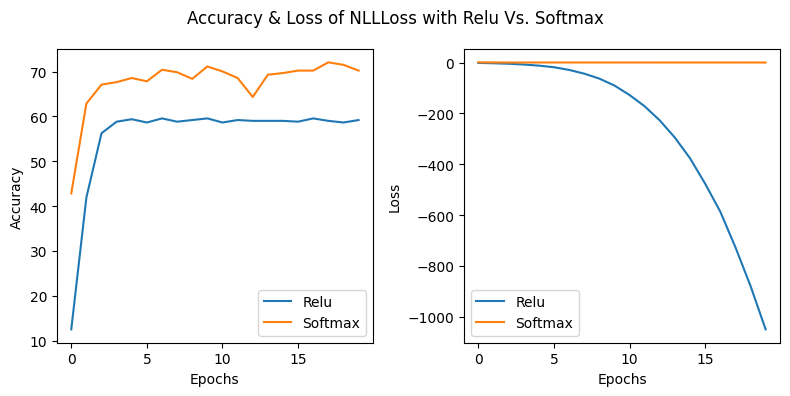

In [124]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(train_acc_relu)
plt.plot(train_acc_soft)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Relu", "Softmax"])

plt.subplot(1,2,2)
plt.plot(train_loss_relu)
plt.plot(train_loss_soft)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Relu", "Softmax"])

plt.suptitle("Accuracy & Loss of NLLLoss with Relu Vs. Softmax")
plt.tight_layout()
plt.show()

Your reason for your choice:

<div>
**Because the loss drops logarithmic, therefore, using logsoftmax would be a good choice.**


</div>


### 4. CrossEntropyLoss (`torch.nn.CrossEntropyLoss`)
- **Description:** Combines `LogSoftmax` and `NLLLoss` in one single class. It computes the cross-entropy loss between the target and the output logits.
- **Use Case:** Widely used for multi-class classification problems.

The mathematical formulation of CrossEntropyLoss is as follows:
\begin{equation}
  \text{CrossEntropy}(y, \hat{y}) = - \sum_{i=1}^{C} y_i \log\left(\frac{e^{\hat{y}_i}}{\sum_{j=1}^{C} e^{\hat{y}_j}}\right)
\end{equation}
  where:
  - \( C \) is the number of classes,
  - \( y_i \) is a one-hot encoded target vector (or a scalar class label),
  - \( \hat{y}_i \) represents the logits (unnormalized model outputs) for each class.
  
  In practice, `torch.nn.CrossEntropyLoss` expects raw logits as input and internally applies the softmax function to convert the logits into probabilities, followed by the negative log-likelihood computation.

- **Background:** Cross-entropy measures the difference between the true distribution \( y \) and the predicted distribution \( \hat{y} \). The function minimizes the negative log-probability assigned to the correct class, effectively penalizing predictions that deviate from the true class, making it a standard choice for classification tasks in deep learning.

Now, let's implement a class called `SimpleMLP_Loss` that has the following architecture:


In [125]:
from torch.nn import CrossEntropyLoss
input_dim = 4
hidden_dim = 10
output_dim = 4
num_hidden_layers = 2
model = SimpleMLP(input_dim, hidden_dim, output_dim, num_hidden_layers).to(device)

# Loss function and optimizer
criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = SimpleMLPTrainer_NLLLoss(model, criterion, optimizer)


# TODO: Train the model
train_loss, train_acc = trainer.train(train_loader, num_epochs=20)

# Evaluate the model
test_loss, test_acc = trainer.evaluate(val_loader)

Epoch 1/20: 100%|██████████| 17/17 [00:00<00:00, 58.57it/s, loss=2.16]


Epoch [1/20], Training Loss: 3.1133, Training Accuracy: 0.18%


Epoch 2/20: 100%|██████████| 17/17 [00:00<00:00, 90.76it/s, loss=1.93]


Epoch [2/20], Training Loss: 2.0968, Training Accuracy: 29.41%


Epoch 3/20: 100%|██████████| 17/17 [00:00<00:00, 66.64it/s, loss=1.19] 


Epoch [3/20], Training Loss: 1.4793, Training Accuracy: 46.88%


Epoch 4/20: 100%|██████████| 17/17 [00:00<00:00, 34.64it/s, loss=0.9]


Epoch [4/20], Training Loss: 1.1727, Training Accuracy: 50.92%


Epoch 5/20: 100%|██████████| 17/17 [00:00<00:00, 25.07it/s, loss=0.884]


Epoch [5/20], Training Loss: 1.0609, Training Accuracy: 55.88%


Epoch 6/20: 100%|██████████| 17/17 [00:00<00:00, 61.57it/s, loss=1.09]


Epoch [6/20], Training Loss: 1.0340, Training Accuracy: 58.82%


Epoch 7/20: 100%|██████████| 17/17 [00:00<00:00, 96.55it/s, loss=0.863]


Epoch [7/20], Training Loss: 1.0349, Training Accuracy: 58.82%


Epoch 8/20: 100%|██████████| 17/17 [00:00<00:00, 52.75it/s, loss=1.2]


Epoch [8/20], Training Loss: 1.0337, Training Accuracy: 59.19%


Epoch 9/20: 100%|██████████| 17/17 [00:00<00:00, 39.66it/s, loss=1.03]


Epoch [9/20], Training Loss: 1.0236, Training Accuracy: 60.11%


Epoch 10/20: 100%|██████████| 17/17 [00:00<00:00, 110.31it/s, loss=0.927]


Epoch [10/20], Training Loss: 1.0342, Training Accuracy: 58.82%


Epoch 11/20: 100%|██████████| 17/17 [00:00<00:00, 104.44it/s, loss=0.974]


Epoch [11/20], Training Loss: 1.0319, Training Accuracy: 59.19%


Epoch 12/20: 100%|██████████| 17/17 [00:00<00:00, 124.51it/s, loss=0.956]


Epoch [12/20], Training Loss: 1.0416, Training Accuracy: 58.64%


Epoch 13/20: 100%|██████████| 17/17 [00:00<00:00, 92.21it/s, loss=0.86]


Epoch [13/20], Training Loss: 1.0317, Training Accuracy: 59.38%


Epoch 14/20: 100%|██████████| 17/17 [00:00<00:00, 28.52it/s, loss=1.21]


Epoch [14/20], Training Loss: 1.0432, Training Accuracy: 58.64%


Epoch 15/20: 100%|██████████| 17/17 [00:00<00:00, 43.13it/s, loss=1.32]


Epoch [15/20], Training Loss: 1.0134, Training Accuracy: 59.56%


Epoch 16/20: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s, loss=0.873]


Epoch [16/20], Training Loss: 1.0339, Training Accuracy: 59.01%


Epoch 17/20: 100%|██████████| 17/17 [00:00<00:00, 44.33it/s, loss=0.9]


Epoch [17/20], Training Loss: 1.0228, Training Accuracy: 59.01%


Epoch 18/20: 100%|██████████| 17/17 [00:00<00:00, 47.05it/s, loss=1.14]


Epoch [18/20], Training Loss: 1.0282, Training Accuracy: 58.64%


Epoch 19/20: 100%|██████████| 17/17 [00:00<00:00, 62.72it/s, loss=1.14]


Epoch [19/20], Training Loss: 1.0245, Training Accuracy: 59.56%


Epoch 20/20: 100%|██████████| 17/17 [00:00<00:00, 66.07it/s, loss=0.969]


Epoch [20/20], Training Loss: 1.0240, Training Accuracy: 59.01%
Validation Loss: 1.1086, Validation Accuracy: 60.94%


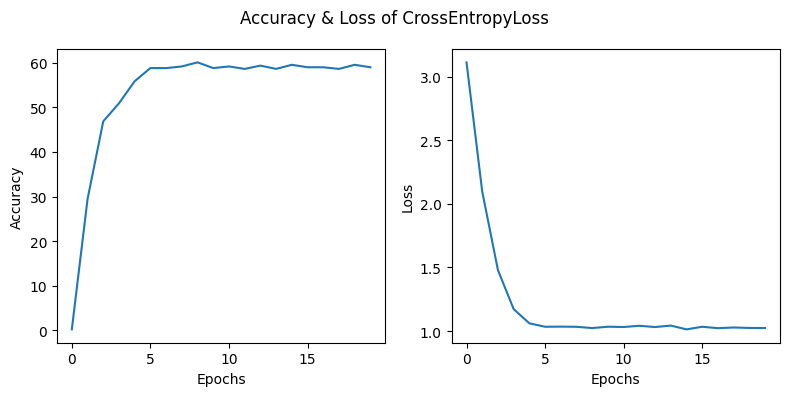

In [126]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(train_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.suptitle("Accuracy & Loss of CrossEntropyLoss")
plt.tight_layout()
plt.show()


### 5. KLDivLoss (`torch.nn.KLDivLoss`)
- **Description:** Kullback-Leibler Divergence Loss measures how one probability distribution diverges from a second, reference distribution. Unlike other loss functions that focus on classification, KL divergence specifically compares the relative entropy between two distributions. It quantifies the information loss when using the predicted distribution to approximate the true distribution.

- **Mathematical Function:**
\begin{equation}
  \text{KL}(P \parallel Q) = \sum_{i=1}^{C} P(i) \left( \log P(i) - \log Q(i) \right)
\end{equation}
  where:
  - \( P \) is the target (true) probability distribution,
  - \( Q \) is the predicted distribution (often the output of `log_softmax`),
  - \( C \) is the number of classes.

  KL divergence is always non-negative, and it equals zero if the two distributions are identical. The loss function expects the model's output to be in the form of log-probabilities (using `log_softmax`) and compares this against a target probability distribution, which is typically a normalized distribution (using softmax).

- **Use Case:** KLDivLoss is frequently used in:
  - **Variational Autoencoders (VAEs):** In VAEs, KL divergence is used to measure how much the learned latent space distribution deviates from a prior distribution (often Gaussian).
  - **Knowledge Distillation:** In teacher-student models, KL divergence is used to transfer the "soft" knowledge from a teacher model to a student model by comparing their output probability distributions.
  - **Reinforcement Learning:** It can be used to update policies while minimizing the divergence from a previous policy.

- **Background:** Kullback-Leibler divergence, a core concept in information theory, measures the inefficiency of assuming the predicted distribution \( Q \) when the true distribution is \( P \). It is asymmetric, meaning that \( KL(P \parallel Q) \neq KL(Q \parallel P) \), so the direction of the comparison matters.

Again, in this part, run your training with Relu at last layer. <span style="color:red; font-weight: bold;">Discuss </span> and explain the difference between the results of the two models. Find a proper solution to the problem.


In [128]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [129]:
# Run with relu activation function
from torch.nn import KLDivLoss
input_dim = 4
hidden_dim = 10
output_dim = 4
num_hidden_layers = 5
model = SimpleMLP(input_dim, hidden_dim, output_dim, num_hidden_layers).to(device)

# Loss function and optimizer
criterion = KLDivLoss(reduction="batchmean")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = SimpleMLPTrainer(model, criterion, optimizer)

# TODO: Train the model
train_loss_relu, train_acc_relu = trainer.train(train_loader, num_epochs=20)

# Evaluate the model
test_loss_relu, test_acc_relu = trainer.evaluate(val_loader)

Epoch 1/20: 100%|██████████| 17/17 [00:00<00:00, 34.27it/s, loss=-0.535]


Epoch [1/20], Training Loss: -0.4999, Training Accuracy: 8.09%


Epoch 2/20: 100%|██████████| 17/17 [00:01<00:00, 16.71it/s, loss=-1.89]


Epoch [2/20], Training Loss: -1.2100, Training Accuracy: 42.83%


Epoch 3/20: 100%|██████████| 17/17 [00:00<00:00, 31.25it/s, loss=-4.55]


Epoch [3/20], Training Loss: -3.1305, Training Accuracy: 59.01%


Epoch 4/20: 100%|██████████| 17/17 [00:00<00:00, 46.35it/s, loss=-16.5]


Epoch [4/20], Training Loss: -8.3069, Training Accuracy: 58.82%


Epoch 5/20: 100%|██████████| 17/17 [00:00<00:00, 24.75it/s, loss=-38.4]


Epoch [5/20], Training Loss: -20.8645, Training Accuracy: 59.74%


Epoch 6/20: 100%|██████████| 17/17 [00:00<00:00, 36.03it/s, loss=-83]


Epoch [6/20], Training Loss: -52.5684, Training Accuracy: 58.82%


Epoch 7/20: 100%|██████████| 17/17 [00:00<00:00, 40.02it/s, loss=-162]


Epoch [7/20], Training Loss: -135.0460, Training Accuracy: 58.64%


Epoch 8/20: 100%|██████████| 17/17 [00:00<00:00, 28.08it/s, loss=-196]


Epoch [8/20], Training Loss: -292.9059, Training Accuracy: 58.64%


Epoch 9/20: 100%|██████████| 17/17 [00:00<00:00, 24.59it/s, loss=-677]


Epoch [9/20], Training Loss: -626.9549, Training Accuracy: 58.82%


Epoch 10/20: 100%|██████████| 17/17 [00:00<00:00, 32.60it/s, loss=-866]


Epoch [10/20], Training Loss: -1274.7846, Training Accuracy: 59.56%


Epoch 11/20: 100%|██████████| 17/17 [00:00<00:00, 31.98it/s, loss=-1.59e+3]


Epoch [11/20], Training Loss: -2482.6012, Training Accuracy: 59.01%


Epoch 12/20: 100%|██████████| 17/17 [00:00<00:00, 38.50it/s, loss=-5.85e+3]


Epoch [12/20], Training Loss: -4539.1406, Training Accuracy: 59.38%


Epoch 13/20: 100%|██████████| 17/17 [00:00<00:00, 32.52it/s, loss=-1.28e+4]


Epoch [13/20], Training Loss: -7962.7061, Training Accuracy: 59.56%


Epoch 14/20: 100%|██████████| 17/17 [00:00<00:00, 17.82it/s, loss=-1.32e+4]


Epoch [14/20], Training Loss: -13473.5260, Training Accuracy: 58.82%


Epoch 15/20: 100%|██████████| 17/17 [00:00<00:00, 21.79it/s, loss=-3.49e+4]


Epoch [15/20], Training Loss: -22099.9701, Training Accuracy: 58.82%


Epoch 16/20: 100%|██████████| 17/17 [00:00<00:00, 46.27it/s, loss=-5.55e+4]


Epoch [16/20], Training Loss: -34982.1684, Training Accuracy: 58.27%


Epoch 17/20: 100%|██████████| 17/17 [00:00<00:00, 100.06it/s, loss=-6.7e+4]


Epoch [17/20], Training Loss: -52916.4193, Training Accuracy: 59.38%


Epoch 18/20: 100%|██████████| 17/17 [00:00<00:00, 76.93it/s, loss=-7.39e+4]


Epoch [18/20], Training Loss: -77990.1875, Training Accuracy: 59.56%


Epoch 19/20: 100%|██████████| 17/17 [00:00<00:00, 36.00it/s, loss=-1.32e+5]


Epoch [19/20], Training Loss: -117038.1498, Training Accuracy: 59.01%


Epoch 20/20: 100%|██████████| 17/17 [00:00<00:00, 35.95it/s, loss=-2.4e+5]


Epoch [20/20], Training Loss: -169311.7027, Training Accuracy: 58.64%
Validation Loss: -212003.2500, Validation Accuracy: 60.94%


In [137]:
# Run with --- activation function
from torch.nn import KLDivLoss
input_dim = 4
hidden_dim = 50
output_dim = 4
num_hidden_layers = 15
model = SimpleMLP(input_dim, hidden_dim, output_dim, num_hidden_layers, last_layer_activation_fn = nn.LogSoftmax).to(device)

# Loss function and optimizer
criterion = KLDivLoss(reduction="batchmean")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = SimpleMLPTrainer(model, criterion, optimizer)

# TODO: Train the model
train_loss_soft, train_acc_soft = trainer.train(train_loader, num_epochs=20)

# Evaluate the model
test_loss_soft, test_acc_soft = trainer.evaluate(val_loader)

Epoch 1/20: 100%|██████████| 17/17 [00:00<00:00, 56.80it/s, loss=2.43]


Epoch [1/20], Training Loss: 2.2660, Training Accuracy: 0.00%


Epoch 2/20: 100%|██████████| 17/17 [00:00<00:00, 64.14it/s, loss=1.04]


Epoch [2/20], Training Loss: 2.2630, Training Accuracy: 28.31%


Epoch 3/20: 100%|██████████| 17/17 [00:00<00:00, 60.70it/s, loss=1.73]


Epoch [3/20], Training Loss: 2.3037, Training Accuracy: 16.18%


Epoch 4/20: 100%|██████████| 17/17 [00:00<00:00, 53.23it/s, loss=2.6]


Epoch [4/20], Training Loss: 2.2935, Training Accuracy: 27.21%


Epoch 5/20: 100%|██████████| 17/17 [00:00<00:00, 52.76it/s, loss=2.25]


Epoch [5/20], Training Loss: 2.3037, Training Accuracy: 4.96%


Epoch 6/20: 100%|██████████| 17/17 [00:00<00:00, 61.10it/s, loss=2.43]


Epoch [6/20], Training Loss: 2.2731, Training Accuracy: 7.72%


Epoch 7/20: 100%|██████████| 17/17 [00:00<00:00, 61.47it/s, loss=3.12]


Epoch [7/20], Training Loss: 2.3037, Training Accuracy: 24.45%


Epoch 8/20: 100%|██████████| 17/17 [00:00<00:00, 67.79it/s, loss=2.77]


Epoch [8/20], Training Loss: 2.2935, Training Accuracy: 19.30%


Epoch 9/20: 100%|██████████| 17/17 [00:00<00:00, 73.90it/s, loss=1.91]


Epoch [9/20], Training Loss: 2.2935, Training Accuracy: 32.90%


Epoch 10/20: 100%|██████████| 17/17 [00:00<00:00, 66.26it/s, loss=2.08]


Epoch [10/20], Training Loss: 2.2120, Training Accuracy: 25.00%


Epoch 11/20: 100%|██████████| 17/17 [00:00<00:00, 63.84it/s, loss=1.73]


Epoch [11/20], Training Loss: 2.2527, Training Accuracy: 33.46%


Epoch 12/20: 100%|██████████| 17/17 [00:00<00:00, 61.66it/s, loss=1.56]


Epoch [12/20], Training Loss: 2.2425, Training Accuracy: 37.32%


Epoch 13/20: 100%|██████████| 17/17 [00:00<00:00, 61.07it/s, loss=2.77]


Epoch [13/20], Training Loss: 2.2425, Training Accuracy: 43.38%


Epoch 14/20: 100%|██████████| 17/17 [00:00<00:00, 30.64it/s, loss=3.12]


Epoch [14/20], Training Loss: 2.2731, Training Accuracy: 43.57%


Epoch 15/20: 100%|██████████| 17/17 [00:00<00:00, 41.22it/s, loss=2.77]


Epoch [15/20], Training Loss: 2.2833, Training Accuracy: 44.12%


Epoch 16/20: 100%|██████████| 17/17 [00:00<00:00, 34.21it/s, loss=2.25]


Epoch [16/20], Training Loss: 2.3139, Training Accuracy: 43.38%


Epoch 17/20: 100%|██████████| 17/17 [00:00<00:00, 26.23it/s, loss=1.91]


Epoch [17/20], Training Loss: 2.2731, Training Accuracy: 44.49%


Epoch 18/20: 100%|██████████| 17/17 [00:00<00:00, 47.38it/s, loss=1.91]


Epoch [18/20], Training Loss: 2.2629, Training Accuracy: 44.30%


Epoch 19/20: 100%|██████████| 17/17 [00:00<00:00, 52.08it/s, loss=1.91]


Epoch [19/20], Training Loss: 2.2629, Training Accuracy: 46.14%


Epoch 20/20: 100%|██████████| 17/17 [00:00<00:00, 33.05it/s, loss=1.73]


Epoch [20/20], Training Loss: 2.2629, Training Accuracy: 44.85%
Validation Loss: 2.1661, Validation Accuracy: 43.75%


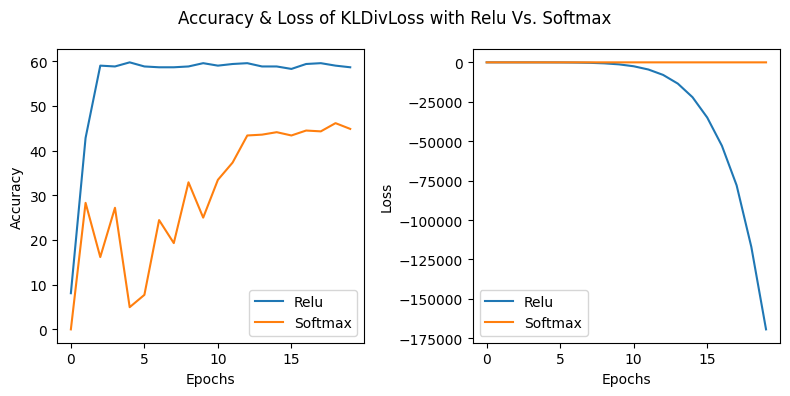

In [138]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(train_acc_relu)
plt.plot(train_acc_soft)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Relu", "Softmax"])

plt.subplot(1,2,2)
plt.plot(train_loss_relu)
plt.plot(train_loss_soft)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Relu", "Softmax"])

plt.suptitle("Accuracy & Loss of KLDivLoss with Relu Vs. Softmax")
plt.tight_layout()
plt.show()

Your reason for your choice:

<div>
**Your answer here**

The accuracy of softmax is more than ReLU and the accuracy varies too much.
</div>

### 6. CosineEmbeddingLoss (`torch.nn.CosineEmbeddingLoss`)
- **Description:** Measures the cosine similarity between two input tensors, `x1` and `x2`, and computes the loss based on a label `y` that indicates whether the tensors should be similar (`y = 1`) or dissimilar (`y = -1`). Cosine similarity focuses on the angle between vectors, disregarding their magnitude.

- **Mathematical Function:**
\begin{equation}
  \text{CosineEmbeddingLoss}(x1, x2, y) =
  \begin{cases}
  1 - \cos(x_1, x_2), & \text{if } y = 1 \\
  \max(0, \cos(x_1, x_2) - \text{margin}), & \text{if } y = -1
  \end{cases}
\end{equation}
  where $ \cos(x_1, x_2) $ is the cosine similarity between the two vectors, and `margin` is a threshold that determines how dissimilar the vectors should be.

- **Use Case:** Commonly used in tasks like face verification, image similarity, and other scenarios where the relative orientation of vectors (angle) is more important than their length, such as in embeddings and metric learning.

- **Background:** Cosine similarity compares the directional alignment of vectors, making it ideal for high-dimensional data where the magnitude may not be as informative. This loss is particularly useful when training models to learn meaningful embeddings that capture semantic similarity.

You'll become more fimiliar with this loss function in future.

---

# Regularization in Machine Learning

## Introduction

Regularization is a fundamental technique in machine learning that helps prevent overfitting by adding a penalty to the loss function. This penalty discourages the model from becoming too complex, ensuring better generalization to unseen data. In this notebook, you will explore the concepts of regularization, understand different types of regularization techniques, and apply them using Python's popular libraries.

## What is Regularization?

Regularization involves adding a regularization term to the loss function used to train machine learning models. This term imposes a constraint on the model's coefficients, effectively reducing their magnitude. By doing so, regularization helps in:

- **Preventing Overfitting:** Ensures the model does not become too tailored to the training data.
- **Improving Generalization:** Enhances the model's performance on new, unseen data.
- **Feature Selection:** Especially in L1 regularization, it can drive some coefficients to zero, effectively selecting important features.

## Types of Regularization

There are several types of regularization techniques, each imposing different constraints on the model's parameters:

### 1. L1 Regularization (Lasso)

L1 regularization adds the absolute value of the magnitude of coefficients as a penalty term to the loss function. It can lead to sparse models where some feature coefficients are exactly zero.

### 2. L2 Regularization (Ridge)

L2 regularization adds the squared magnitude of coefficients as a penalty term to the loss function. It tends to shrink the coefficients evenly but does not set them to zero.

### 3. Elastic Net

Elastic Net combines both L1 and L2 regularization penalties. It balances the benefits of both Lasso and Ridge methods, allowing for feature selection and coefficient shrinkage.

## Homework Time!
Import Iris dataset from sklearn.datasets and apply ridge regression with different alpha values. Then, create a gif that shows the changes of the classification boundary with respect to alpha values.

Import the libs that you need and start coding!

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from PIL import Image
from io import BytesIO
import imageio
import warnings


# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

Load the Iris dataset and select Setosa and Versicolor classes

In [133]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Select only two classes for binary classification (Setosa and Versicolor)
X = X[y != 2]  # Removing the third class
y = y[y != 2]

# Select two features for 2D visualization (Sepal Length and Petal Length)
X = X[:, [0, 2]]  # Sepal Length and Petal Length

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Define Function to Plot Decision Boundary

In [134]:
def plot_decision_boundary(model, X, y, alpha):
    # Define the grid (use meshgrid)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predict over the grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    # Create a figure
    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, levels=[-0.1, 0.1, 1.1], colors=['blue', 'red'])

    # Scatter plot of the training data
    scatter = ax.scatter(
        X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', s=50
    )

    # Title and labels
    ax.set_title(f'MLP Decision Boundary (alpha={alpha})')
    ax.set_xlabel('Sepal Length (standardized)')
    ax.set_ylabel('Petal Length (standardized)')

    # Remove axes for clarity
    ax.set_xticks([])
    ax.set_yticks([])

    # Tight layout
    plt.tight_layout()

    # Save the plot to a BytesIO object
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

Train MLP with Varying Alpha Values and Collect Images

In [135]:
from sklearn.neural_network import MLPClassifier

def create_decision_boundary_gif(alpha_values, X_train, y_train, n_neurons):

    # List to store images
    images = []

    for idx, alpha in enumerate(alpha_values):
        print(f"Processing alpha={alpha:.4f} ({idx + 1}/{len(alpha_values)})")

        # Create and train the MLP
        mlp = MLPClassifier(hidden_layer_sizes=(n_neurons,), alpha=alpha, max_iter=1000, random_state=42)
        mlp.fit(X_train, y_train)

        # Plot decision boundary and get the image
        img = plot_decision_boundary(mlp, X_train, y_train, alpha)
        images.append(img)

    # Save the images as a GIF
    gif_filename = 'mlp_classification_boundaries.gif'
    images[0].save(
        gif_filename,
        save_all=True,
        append_images=images[1:],
        duration=500,
        loop=0
    )

    print(f"GIF saved as '{gif_filename}'")

    # return the gif
    return gif_filename

## RUN

In [136]:
# Use np.logspace to generate alpha values, with at least 20 values
alpha_values = np.logspace(-3, 3, 20)
# Define the number of neurons in the hidden layer
n_neurons =  10

# Create the decision boundary GIF
gif_dir = create_decision_boundary_gif(alpha_values, X_train, y_train, n_neurons)

Processing alpha=0.0010 (1/20)
Processing alpha=0.0021 (2/20)
Processing alpha=0.0043 (3/20)
Processing alpha=0.0089 (4/20)
Processing alpha=0.0183 (5/20)
Processing alpha=0.0379 (6/20)
Processing alpha=0.0785 (7/20)
Processing alpha=0.1624 (8/20)
Processing alpha=0.3360 (9/20)
Processing alpha=0.6952 (10/20)
Processing alpha=1.4384 (11/20)
Processing alpha=2.9764 (12/20)
Processing alpha=6.1585 (13/20)
Processing alpha=12.7427 (14/20)
Processing alpha=26.3665 (15/20)
Processing alpha=54.5559 (16/20)
Processing alpha=112.8838 (17/20)
Processing alpha=233.5721 (18/20)
Processing alpha=483.2930 (19/20)
Processing alpha=1000.0000 (20/20)
GIF saved as 'mlp_classification_boundaries.gif'


Your gif should look like this:

<div style="text-align: center;">

### **Multilayer Perceptron Classification Boundaries**

![Classification Boundaries](mlp_classification_boundaries_example.gif)

*Figure 1: Demonstration of classification boundaries created by a Multilayer Perceptron (MLP) model.*

</div>

